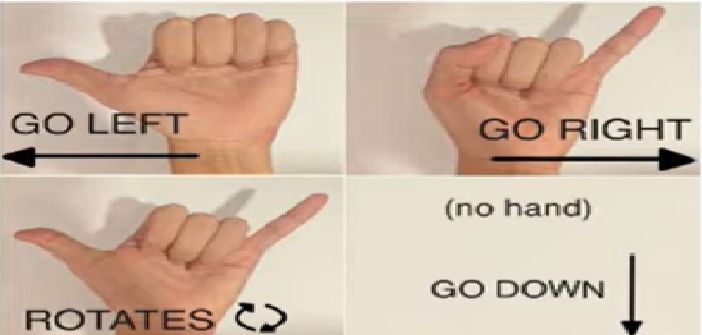

In [1]:
import pygame
import cv2
import mediapipe as mp
import os
import sys
import random

'''
Thank you "Tech With Tim" and "Murtaza's Workshop" for great free python tutorials on youtube that help me so much with this work
Tech With Tim | Making Tetris Tutorial: https://www.youtube.com/watch?v=uoR4ilCWwKA
Murtaza's Workshop | Hand Tracking Tutorial: https://www.youtube.com/watch?v=p5Z_GGRCI5s
'''

#Getting mediapipe: Hands ready
mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils

#Capture webcam
cam = cv2.VideoCapture(0)

#Prepare pygame window position, fonts and background music
os.environ['SDL_VIDEO_WINDOW_POS'] ="560,30"
pygame.font.init()
pygame.mixer.init()
#pygame.mixer.music.load('Tetris_theme.mp3')

#Global variables
s_width = 800
s_height = 690
play_width = 300  # meaning 300 // 10 = 30 width per block
play_height = 600  # meaning 600 // 20 = 30 height per block
block_size = 30
top_left_x = (s_width - play_width) // 2
top_left_y = s_height - play_height - 10

#The shapes with all possible rotations
S = [['.....',
      '.....',
      '..00.',
      '.00..',
      '.....'],
     ['.....',
      '..0..',
      '..00.',
      '...0.',
      '.....']]

Z = [['.....',
      '.....',
      '.00..',
      '..00.',
      '.....'],
     ['.....',
      '..0..',
      '.00..',
      '.0...',
      '.....']]

I = [['..0..',
      '..0..',
      '..0..',
      '..0..',
      '.....'],
     ['.....',
      '0000.',
      '.....',
      '.....',
      '.....']]

O = [['.....',
      '.....',
      '.00..',
      '.00..',
      '.....']]

J = [['.....',
      '.0...',
      '.000.',
      '.....',
      '.....'],
     ['.....',
      '..00.',
      '..0..',
      '..0..',
      '.....'],
     ['.....',
      '.....',
      '.000.',
      '...0.',
      '.....'],
     ['.....',
      '..0..',
      '..0..',
      '.00..',
      '.....']]

L = [['.....',
      '...0.',
      '.000.',
      '.....',
      '.....'],
     ['.....',
      '..0..',
      '..0..',
      '..00.',
      '.....'],
     ['.....',
      '.....',
      '.000.',
      '.0...',
      '.....'],
     ['.....',
      '.00..',
      '..0..',
      '..0..',
      '.....']]

T = [['.....',
      '..0..',
      '.000.',
      '.....',
      '.....'],
     ['.....',
      '..0..',
      '..00.',
      '..0..',
      '.....'],
     ['.....',
      '.....',
      '.000.',
      '..0..',
      '.....'],
     ['.....',
      '..0..',
      '.00..',
      '..0..',
      '.....']]

#index 0-6 get you a shape and its corresponding colours
shapes = [S, Z, I, O, J, L, T]
shape_colors = [(0, 230, 115), (255, 51, 51), (0, 204, 255), (255, 255, 128), (0, 102, 255), (255, 140, 26), (204, 51, 255)]

#Class for the Shapes
class Piece(object):  # *
    def __init__(self, x, y, shape):
        self.x = x
        self.y = y
        self.shape = shape
        self.color = shape_colors[shapes.index(shape)]
        self.rotation = 0

#create the grid
def create_grid(locked_pos={}):  # *
    grid = [[(0,0,0) for _ in range(10)] for _ in range(20)]

    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if (j, i) in locked_pos:
                c = locked_pos[(j,i)]
                grid[i][j] = c
    return grid

#convert the shapes into its positions
def convert_shape_format(shape):
    positions = []
    format = shape.shape[shape.rotation % len(shape.shape)]

    for i, line in enumerate(format):
        row = list(line)
        for j, column in enumerate(row):
            if column == '0':
                positions.append((shape.x + j, shape.y + i))

    for i, pos in enumerate(positions):
        positions[i] = (pos[0] - 2, pos[1] - 4)

    return positions

#test whether or not the falling shape is in a valid space
def valid_space(shape, grid):
    accepted_pos = [[(j, i) for j in range(10) if grid[i][j] == (0,0,0)] for i in range(20)]
    accepted_pos = [j for sub in accepted_pos for j in sub]

    formatted = convert_shape_format(shape)

    for pos in formatted:
        if pos not in accepted_pos:
            if pos[1] > -1:
                return False
    return True

#check whether or not the user have lost
def check_lost(positions):
    for pos in positions:
        x, y = pos
        if y < 1:
            return True

    return False

#get a random shape
def get_shape():
    return Piece(5, 0, random.choice(shapes))

#put a text in the middle of the screen
def draw_text_middle(surface, text, size, color):
    font = pygame.font.SysFont("britannic", size, bold=True)
    label = font.render(text, 1, color)

    surface.blit(label, (top_left_x + play_width /2 - (label.get_width()/2), top_left_y + play_height/2 - label.get_height()/2))

#draw the lines onto the grid
def draw_grid(surface, grid):
    sx = top_left_x
    sy = top_left_y

    for i in range(len(grid)):
        pygame.draw.line(surface, (128,128,128), (sx, sy + i*block_size), (sx+play_width, sy+ i*block_size))
        for j in range(len(grid[i])):
            pygame.draw.line(surface, (128, 128, 128), (sx + j*block_size, sy),(sx + j*block_size, sy + play_height))

#clear a row
def clear_rows(grid, locked):

    inc = 0
    for i in range(len(grid)-1, -1, -1):
        row = grid[i]
        if (0,0,0) not in row:
            inc += 1
            ind = i
            for j in range(len(row)):
                try:
                    del locked[(j,i)]
                except:
                    continue

    if inc > 0:
        for key in sorted(list(locked), key=lambda x: x[1])[::-1]:
            x, y = key
            if y < ind:
                newKey = (x, y + inc)
                locked[newKey] = locked.pop(key)

    return inc

#draw the window that shows the next shape
def draw_next_shape(shape, surface):
    font = pygame.font.SysFont('britannic', 30)
    label = font.render('Next Shape', 1, (255,255,255))

    sx = top_left_x + play_width + 50
    sy = top_left_y + play_height/2 - 100
    format = shape.shape[shape.rotation % len(shape.shape)]

    for i, line in enumerate(format):
        row = list(line)
        for j, column in enumerate(row):
            if column == '0':
                pygame.draw.rect(surface, shape.color, (sx + j*block_size, sy + i*block_size, block_size, block_size), 0)

    surface.blit(label, (sx + 10, sy - 40))

#draw the main window
def draw_window(surface, grid, score=0):
    surface.fill((0, 0, 0))

    pygame.font.init()
    font = pygame.font.SysFont('britannic', 60)
    label = font.render('TETRIS', 1, (255, 255, 255))

    surface.blit(label, (top_left_x + play_width / 2 - (label.get_width() / 2), 15))

    #show current score
    font = pygame.font.SysFont('britannic', 30)
    label = font.render('Score: ' + str(score), 1, (255,255,255))

    sx = top_left_x + play_width + 50
    sy = top_left_y + play_height/2 - 100

    surface.blit(label, (sx + 20, sy + 160))

    for i in range(len(grid)):
        for j in range(len(grid[i])):
            pygame.draw.rect(surface, grid[i][j], (top_left_x + j*block_size, top_left_y + i*block_size, block_size, block_size), 0)

    pygame.draw.rect(surface, (215, 215, 215), (top_left_x, top_left_y, play_width, play_height), 5)

    draw_grid(surface, grid)

#add scores that correspond to the amount of rows cleared
def add_score(rows):
    conversion = {
        0: 0,
        1: 40,
        2: 100,
        3: 300,
        4: 1200
    }
    return conversion.get(rows)

#THE MAIN FUNCTION THAT RUNS THE GAME
def main(win):
    locked_positions = {}
    grid = create_grid(locked_positions)

    change_piece = False
    run = True
    current_piece = get_shape()
    next_piece = get_shape()
    clock = pygame.time.Clock()
    fall_time = 0
    fall_speed_real = 0.45
    fall_speed = fall_speed_real
    level_time = 0
    score = 0

    left_wait = 0
    right_wait = 0
    rotate_wait = 0
    down_wait = 0
    fall_speed_down = 0.1

    #THE MAIN WHILE LOOP
    while run:
        grid = create_grid(locked_positions)

        fall_time += clock.get_rawtime()
        level_time += clock.get_rawtime()
        clock.tick()

        #Set up the hand tracker
        success, img = cam.read()
        imgg = cv2.flip(img, 1)
        imgRGB = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)

        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                for id, lm in enumerate(handLms.landmark):
                    h, w, c = imgg.shape
                    if id == 0:
                        x = []
                        y = []
                    x.append(int((lm.x) * w))
                    y.append(int((1 - lm.y) * h))

                    #This will track the hand gestures
                    if len(y) > 20:
                        if (x[0] > x[3] > x[4]) and not(y[20] > y[17]):
                           left_wait += 1
                        if not(x[0] > x[3] > x[4]) and (y[20] > y[17]):
                            right_wait += 1
                        if (x[0] > x[3] > x[4]) and (y[20] > y[17]):
                            rotate_wait += 1


                mpDraw.draw_landmarks(imgg, handLms, mpHands.HAND_CONNECTIONS)

        else:
            down_wait += 1

        cv2.namedWindow("WebCam")
        cv2.moveWindow("WebCam", 20, 121)
        cv2.imshow("WebCam", imgg)
        cv2.waitKey(1)

        #every 10 sec, shapes move 0.03 sec faster (peak at 0.25)
        if level_time/1000 > 10:
            level_time = 0
            if fall_speed_real > 0.25:
                fall_speed_real -= 0.03

        #if enough time (fall_speed) have passsed, piece moves down 1 block
        if fall_time/1000 > fall_speed:
            fall_time = 0
            current_piece.y += 1
            if not(valid_space(current_piece, grid)) and current_piece.y > 0:
                current_piece.y -= 1
                change_piece = True

        #"if you gesture to the LEFT for at least 4 frames, piece move LEFT"
        if left_wait >= 4:
            current_piece.x -= 1
            if not (valid_space(current_piece, grid)):
                current_piece.x += 1
            left_wait = 0
            right_wait = 0
            rotate_wait = 0
            down_wait = 0

        #"if you gesture to the RIGHT for at least 4 frames, piece move RIGHT"
        if right_wait >= 4:
            current_piece.x += 1
            if not (valid_space(current_piece, grid)):
                current_piece.x -= 1
            left_wait = 0
            right_wait = 0
            rotate_wait = 0
            down_wait = 0

        #"if you gesture to ROTATE  for at least 4 frames, piece ROTATES"
        if rotate_wait >= 4:
            current_piece.rotation += 1
            if not (valid_space(current_piece, grid)):
                current_piece.rotation -= 1
            left_wait = 0
            right_wait = 0
            rotate_wait = 0
            down_wait = 0

        #"if you gesture to go DOWN (no hand on the screen) for at least 5 frames, piece go DOWN (moves very fast)"
        if down_wait >= 5:
            fall_speed = fall_speed_down
            left_wait = 0
            right_wait = 0
            rotate_wait = 0
            down_wait = 0

        shape_pos = convert_shape_format(current_piece)

        #colour the grid where the shape is
        for i in range(len(shape_pos)):
            x, y = shape_pos[i]
            if y > -1:
                grid[y][x] = current_piece.color

        if change_piece:
            for pos in shape_pos:
                p = (pos[0], pos[1])
                locked_positions[p] = current_piece.color
            current_piece = next_piece
            next_piece = get_shape()
            change_piece = False
            score += add_score(clear_rows(grid, locked_positions))
            fall_speed = fall_speed_real
            down_wait = 0

        draw_window(win, grid, score)
        draw_next_shape(next_piece, win)
        pygame.display.update()

        if check_lost(locked_positions):
            draw_text_middle(win, "YOU LOST!", 80, (255,255,255))
            pygame.display.update()
            pygame.time.delay(1500)
            run = False

#Menu screen that will lead to the main function
def main_menu(win):
    run = True
    while run:
        win.fill((0,0,0))
        draw_text_middle(win, 'Press Any Key To Start', 60, (255,255,255))
        pygame.display.update()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
            if event.type == pygame.KEYDOWN:
                #pygame.mixer.music.play()
                main(win)


    pygame.display.quit()
    sys.exit()
win = pygame.display.set_mode((s_width, s_height))
pygame.display.set_caption('TETRIS')
main_menu(win)

pygame 2.5.2 (SDL 2.28.3, Python 3.9.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\trueh\anaconda3\envs\test\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


KeyboardInterrupt: 